# NLP Sentiment Analysis using TextBlob #

In [2]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import nltk
import re
import string
import emoji
import contractions
# import datatable as dt

from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from langdetect import detect
from deep_translator import GoogleTranslator
from nltk.corpus import stopwords, wordnet   # inaugural
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.probability import FreqDist
from wordcloud import WordCloud
from textblob import TextBlob
from textblob.classifiers import NaiveBayesClassifier

In [3]:
# Load and preview the dataset
df = pd.read_csv('AirBnb_reviews.csv')
df.sample(7)

,listing_id,id,date,reviewer_id,reviewer_name,comments
303887,50383849.0,5.737670e+17,3/2/2022,189006567,Nathan,"Un très bel hôtel, très accueillant ! La chamb..."
237598,24137393.0,2.831464e+08,6/29/2018,35875626,Lisa-Marie,Staying at Rob's apartment was really uncompli...
266883,31136615.0,5.858229e+08,1/1/2020,245805254,Viola,"Posizione ottima!<br/>Camera nuova , molto acc..."
36198,771343.0,6.534042e+08,8/19/2020,53208415,Chiara,We had a really pleasant stay at Marcel's apar...
131888,9272999.0,4.008044e+08,1/13/2019,86056415,Cj,I enjoyed my stay there
282163,38835232.0,4.468480e+17,9/8/2021,11245741,Bradford,"Olivier and Tessa were great hosts: flexible, ..."
201866,18622506.0,6.954940e+17,8/17/2022,426376362,Yueheng,"The studio is nice, though it gets very warm i..."


## EDA & Data Preprocessing ##

In [5]:
# Check the number of rows and columns of the dataset
df.shape

(342904, 6)

In [6]:
# Check for null values
df.isnull().sum()

listing_id        0
id                0
date              0
reviewer_id       0
reviewer_name     0
comments         16
dtype: int64

In [7]:
# View rows with null values in the 'comments' column
rows_with_nulls = df[df.isnull().any(axis=1)]
rows_with_nulls

,listing_id,id,date,reviewer_id,reviewer_name,comments
141586,10441222.0,1.494409e+08,5/4/2017,127283548,Becca,NaN
190366,16081933.0,4.458457e+08,4/30/2019,219747165,Roger,NaN
215261,20063721.0,3.490844e+08,11/16/2018,1112994,Sara,NaN
246744,25310162.0,4.084152e+08,2/4/2019,786573,Alexander,NaN
251711,28798431.0,6.185660e+17,5/3/2022,449718855,Juan Carlos,NaN
256036,30418746.0,4.769594e+08,6/27/2019,250741909,Neil,NaN
260523,32325935.0,5.968560e+17,4/3/2022,90710066,Auguste,NaN
270519,33439715.0,5.853400e+17,3/18/2022,195206931,Graham,NaN
289331,42446371.0,4.511790e+17,9/14/2021,51833070,Jordi,NaN
294242,45045046.0,5.020080e+17,11/23/2021,429792878,Victor,NaN


In [8]:
# Drop all the rows with null values
df.dropna(inplace=True)

# Check for null values
df.isnull().sum()

listing_id       0
id               0
date             0
reviewer_id      0
reviewer_name    0
comments         0
dtype: int64

In [9]:
# Remove the unnecessary columns
df = df[['reviewer_name', 'comments']]

# Preview the trimmed dataset
df.sample(7)

,reviewer_name,comments
164555,Kourosh,Mauro do have a good communication before the ...
129421,Eduardo,Harry es un estupendo anfitrión. Su casa es un...
68721,Emma,Ester made us feel very welcome on our arrival...
207505,J,Unique and stylish houseboat in a quiet but co...
328139,Henk,"Heerlijke plek, groot huis, grote tuin en vlak..."
82881,Daniel,Perfect spot for a visit to Amsterdam!<br/>Gre...
258778,Mathieu,très bon accueil de Jacqueline !<br/>apparteme...


In [10]:
# Check for any non-text comment
df.sort_values(by='comments', ascending=False).head(10)

,reviewer_name,comments
276536,Faleh,🧡
281739,Yuval,🧠💍
327922,政揚,🦍🦍🦍
281629,Yamila,🥰
300161,Sebastian,🤡
306910,Laurits,🤞
329245,Mohamed,🤝👍
339965,Ronan,🤝
310273,Muhammed,🤙🏼
156930,Christopher,🤙


In [11]:
# Function to convert emojis to text
def emoji_to_text(text):
    return emoji.demojize(text)

# Apply the function to the 'comments' column and insert the converted emojis into a new column 'comments_cleaned'
df['comments_cleaned'] = df['comments'].apply(emoji_to_text)

# Apply the function to the 'reviewer_name' column and insert the converted emojis into a new column 'reviewer_name_cleaned'
df['reviewer_name_cleaned'] = df['reviewer_name'].apply(emoji_to_text)

In [12]:
# Double check the converted emoji
df.sort_values(by='comments', ascending=False).head(50)

,reviewer_name,comments,comments_cleaned,reviewer_name_cleaned
276536,Faleh,🧡,:orange_heart:,Faleh
281739,Yuval,🧠💍,:brain::ring:,Yuval
327922,政揚,🦍🦍🦍,:gorilla::gorilla::gorilla:,政揚
281629,Yamila,🥰,:smiling_face_with_hearts:,Yamila
300161,Sebastian,🤡,:clown_face:,Sebastian
306910,Laurits,🤞,:crossed_fingers:,Laurits
329245,Mohamed,🤝👍,:handshake::thumbs_up:,Mohamed
339965,Ronan,🤝,:handshake:,Ronan
310273,Muhammed,🤙🏼,:call_me_hand_medium-light_skin_tone:,Muhammed
156930,Christopher,🤙,:call_me_hand:,Christopher


In [13]:
# Removing URLs
df['comments_cleaned'] = df['comments_cleaned'].apply(lambda x: re.sub(r'http\S+|www.\S+', '', x))
df['reviewer_name_cleaned'] = df['reviewer_name_cleaned'].apply(lambda x: re.sub(r'http\S+|www.\S+', '', x))

In [14]:
df.sort_values(by='comments_cleaned', ascending=False)

,reviewer_name,comments,comments_cleaned,reviewer_name_cleaned
162594,Hitomi,ﾛｹｰｼｮﾝは最高です。<br/>日本人は朝食をしっかり食べますよね。B&Bなら朝食がついて...,ﾛｹｰｼｮﾝは最高です。<br/>日本人は朝食をしっかり食べますよね。B&Bなら朝食がついて...,Hitomi
237848,Yutaka,ﾛｹｰｼｮﾝはよいですが､今まで見たことも無い様な狭くて急な階段がｶﾞﾝです。<br/>年配...,ﾛｹｰｼｮﾝはよいですが､今まで見たことも無い様な狭くて急な階段がｶﾞﾝです。<br/>年配...,Yutaka
276722,齊藤,ﾎﾃﾙの前の公園が大きくて､散歩にちょうどいい。部屋は綺麗に掃除してあります。ﾌﾛﾝﾄ対応も...,ﾎﾃﾙの前の公園が大きくて､散歩にちょうどいい。部屋は綺麗に掃除してあります。ﾌﾛﾝﾄ対応も...,齊藤
226061,響子,ﾎｽﾄはとても親切の方で2匹の犬もとても可愛いです。場所もよく近くにはｽｰﾊﾟｰがたくさんあ...,ﾎｽﾄはとても親切の方で2匹の犬もとても可愛いです。場所もよく近くにはｽｰﾊﾟｰがたくさんあ...,響子
187638,Akiko,ﾎｽﾄはとても親切で<br/>ｽﾃｷな笑顔の持ち主です<br/><br/>返信も早いです<b...,ﾎｽﾄはとても親切で<br/>ｽﾃｷな笑顔の持ち主です<br/><br/>返信も早いです<b...,Akiko
...,...,...,...,...
61275,Thia (& Barry),"\r<br/> I am reviewing a very unpleasant, un...","\r<br/> I am reviewing a very unpleasant, un...",Thia (& Barry)
20715,Alexander,\r<br/>\r<br/>2. This apartment is an ideal ch...,\r<br/>\r<br/>2. This apartment is an ideal ch...,Alexander
68084,Mila,\r<br/>\r<br/>\r<br/>la biennvenida muy simpat...,\r<br/>\r<br/>\r<br/>la biennvenida muy simpat...,Mila
51816,Judith,\r<br/>\r<br/>\r<br/>We stayed in Lot's flat f...,\r<br/>\r<br/>\r<br/>We stayed in Lot's flat f...,Judith


In [15]:
# Removing HTML tags
df['comments_cleaned'] = df['comments_cleaned'].apply(lambda x: BeautifulSoup(x, "lxml").text)
df['reviewer_name_cleaned'] = df['reviewer_name_cleaned'].apply(lambda x: BeautifulSoup(x, "lxml").text)

C:\Users\Daniel\AppData\Local\Temp\ipykernel_32104\3813491045.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  df['comments_cleaned'] = df['comments_cleaned'].apply(lambda x: BeautifulSoup(x, "lxml").text)
C:\Users\Daniel\AppData\Local\Temp\ipykernel_32104\3813491045.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  df['reviewer_name_cleaned'] = df['reviewer_name_cleaned'].apply(lambda x: BeautifulSoup(x, "lxml").text)


In [16]:
df.sort_values(by='comments_cleaned', ascending=False)

,reviewer_name,comments,comments_cleaned,reviewer_name_cleaned
162594,Hitomi,ﾛｹｰｼｮﾝは最高です。<br/>日本人は朝食をしっかり食べますよね。B&Bなら朝食がついて...,ﾛｹｰｼｮﾝは最高です。日本人は朝食をしっかり食べますよね。B&Bなら朝食がついているかと思...,Hitomi
237848,Yutaka,ﾛｹｰｼｮﾝはよいですが､今まで見たことも無い様な狭くて急な階段がｶﾞﾝです。<br/>年配...,ﾛｹｰｼｮﾝはよいですが､今まで見たことも無い様な狭くて急な階段がｶﾞﾝです。年配者や酔っ払...,Yutaka
276722,齊藤,ﾎﾃﾙの前の公園が大きくて､散歩にちょうどいい。部屋は綺麗に掃除してあります。ﾌﾛﾝﾄ対応も...,ﾎﾃﾙの前の公園が大きくて､散歩にちょうどいい。部屋は綺麗に掃除してあります。ﾌﾛﾝﾄ対応も...,齊藤
226061,響子,ﾎｽﾄはとても親切の方で2匹の犬もとても可愛いです。場所もよく近くにはｽｰﾊﾟｰがたくさんあ...,ﾎｽﾄはとても親切の方で2匹の犬もとても可愛いです。場所もよく近くにはｽｰﾊﾟｰがたくさんあ...,響子
187638,Akiko,ﾎｽﾄはとても親切で<br/>ｽﾃｷな笑顔の持ち主です<br/><br/>返信も早いです<b...,ﾎｽﾄはとても親切でｽﾃｷな笑顔の持ち主です返信も早いですお部屋もとても清潔で冬はとても暖か...,Akiko
...,...,...,...,...
51816,Judith,\r<br/>\r<br/>\r<br/>We stayed in Lot's flat f...,We stayed in Lot's flat for 6 days and enjoy...,Judith
47219,Loïc,\r<br/>\r<br/>\r<br/>\r<br/>Very nice trip in...,Very nice trip in Amsterdam! Thanks to Eva'...,Loïc
61275,Thia (& Barry),"\r<br/> I am reviewing a very unpleasant, un...","I am reviewing a very unpleasant, unprofess...",Thia (& Barry)
115308,Delphine,\r<br/>\r<br/>\r<br/>\r<br/>\r<br/>\r<br/>\r<b...,Apartment very nice...,Delphine


In [17]:
# Removing punctuation
df['comments_cleaned'] = df['comments_cleaned'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
df['reviewer_name_cleaned'] = df['reviewer_name_cleaned'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

In [18]:
df.sort_values(by='comments_cleaned', ascending=False)

,reviewer_name,comments,comments_cleaned,reviewer_name_cleaned
162594,Hitomi,ﾛｹｰｼｮﾝは最高です。<br/>日本人は朝食をしっかり食べますよね。B&Bなら朝食がついて...,ﾛｹｰｼｮﾝは最高です。日本人は朝食をしっかり食べますよね。BBなら朝食がついているかと思っ...,Hitomi
237848,Yutaka,ﾛｹｰｼｮﾝはよいですが､今まで見たことも無い様な狭くて急な階段がｶﾞﾝです。<br/>年配...,ﾛｹｰｼｮﾝはよいですが､今まで見たことも無い様な狭くて急な階段がｶﾞﾝです。年配者や酔っ払...,Yutaka
276722,齊藤,ﾎﾃﾙの前の公園が大きくて､散歩にちょうどいい。部屋は綺麗に掃除してあります。ﾌﾛﾝﾄ対応も...,ﾎﾃﾙの前の公園が大きくて､散歩にちょうどいい。部屋は綺麗に掃除してあります。ﾌﾛﾝﾄ対応も...,齊藤
226061,響子,ﾎｽﾄはとても親切の方で2匹の犬もとても可愛いです。場所もよく近くにはｽｰﾊﾟｰがたくさんあ...,ﾎｽﾄはとても親切の方で2匹の犬もとても可愛いです。場所もよく近くにはｽｰﾊﾟｰがたくさんあ...,響子
187638,Akiko,ﾎｽﾄはとても親切で<br/>ｽﾃｷな笑顔の持ち主です<br/><br/>返信も早いです<b...,ﾎｽﾄはとても親切でｽﾃｷな笑顔の持ち主です返信も早いですお部屋もとても清潔で冬はとても暖か...,Akiko
...,...,...,...,...
321175,Antoinette,-,,Antoinette
317249,Luca Carlo,.,,Luca Carlo
285272,Iris,.,,Iris
22170,Derek,.,,Derek


In [19]:
# Removing numbers
df['comments_cleaned'] = df['comments_cleaned'].apply(lambda x: re.sub(r'\d+', '', x))
df['reviewer_name_cleaned'] = df['reviewer_name_cleaned'].apply(lambda x: re.sub(r'\d+', '', x))

In [20]:
df.sort_values(by='comments_cleaned', ascending=False)

,reviewer_name,comments,comments_cleaned,reviewer_name_cleaned
162594,Hitomi,ﾛｹｰｼｮﾝは最高です。<br/>日本人は朝食をしっかり食べますよね。B&Bなら朝食がついて...,ﾛｹｰｼｮﾝは最高です。日本人は朝食をしっかり食べますよね。BBなら朝食がついているかと思っ...,Hitomi
237848,Yutaka,ﾛｹｰｼｮﾝはよいですが､今まで見たことも無い様な狭くて急な階段がｶﾞﾝです。<br/>年配...,ﾛｹｰｼｮﾝはよいですが､今まで見たことも無い様な狭くて急な階段がｶﾞﾝです。年配者や酔っ払...,Yutaka
276722,齊藤,ﾎﾃﾙの前の公園が大きくて､散歩にちょうどいい。部屋は綺麗に掃除してあります。ﾌﾛﾝﾄ対応も...,ﾎﾃﾙの前の公園が大きくて､散歩にちょうどいい。部屋は綺麗に掃除してあります。ﾌﾛﾝﾄ対応も...,齊藤
226061,響子,ﾎｽﾄはとても親切の方で2匹の犬もとても可愛いです。場所もよく近くにはｽｰﾊﾟｰがたくさんあ...,ﾎｽﾄはとても親切の方で匹の犬もとても可愛いです。場所もよく近くにはｽｰﾊﾟｰがたくさんあり...,響子
187638,Akiko,ﾎｽﾄはとても親切で<br/>ｽﾃｷな笑顔の持ち主です<br/><br/>返信も早いです<b...,ﾎｽﾄはとても親切でｽﾃｷな笑顔の持ち主です返信も早いですお部屋もとても清潔で冬はとても暖か...,Akiko
...,...,...,...,...
310928,Thomas,.,,Thomas
62031,Jodi,.,,Jodi
335196,فهد,.,,فهد
318868,Hauke,?,,Hauke


In [21]:
# Removing extra spaces
df['comments_cleaned'] = df['comments_cleaned'].apply(lambda x: ' '.join(x.split()))
df['reviewer_name_cleaned'] = df['reviewer_name_cleaned'].apply(lambda x: ' '.join(x.split()))

In [22]:
df.sort_values(by='comments_cleaned', ascending=False)

,reviewer_name,comments,comments_cleaned,reviewer_name_cleaned
162594,Hitomi,ﾛｹｰｼｮﾝは最高です。<br/>日本人は朝食をしっかり食べますよね。B&Bなら朝食がついて...,ﾛｹｰｼｮﾝは最高です。日本人は朝食をしっかり食べますよね。BBなら朝食がついているかと思っ...,Hitomi
237848,Yutaka,ﾛｹｰｼｮﾝはよいですが､今まで見たことも無い様な狭くて急な階段がｶﾞﾝです。<br/>年配...,ﾛｹｰｼｮﾝはよいですが､今まで見たことも無い様な狭くて急な階段がｶﾞﾝです。年配者や酔っ払...,Yutaka
276722,齊藤,ﾎﾃﾙの前の公園が大きくて､散歩にちょうどいい。部屋は綺麗に掃除してあります。ﾌﾛﾝﾄ対応も...,ﾎﾃﾙの前の公園が大きくて､散歩にちょうどいい。部屋は綺麗に掃除してあります。ﾌﾛﾝﾄ対応も...,齊藤
226061,響子,ﾎｽﾄはとても親切の方で2匹の犬もとても可愛いです。場所もよく近くにはｽｰﾊﾟｰがたくさんあ...,ﾎｽﾄはとても親切の方で匹の犬もとても可愛いです。場所もよく近くにはｽｰﾊﾟｰがたくさんあり...,響子
187638,Akiko,ﾎｽﾄはとても親切で<br/>ｽﾃｷな笑顔の持ち主です<br/><br/>返信も早いです<b...,ﾎｽﾄはとても親切でｽﾃｷな笑顔の持ち主です返信も早いですお部屋もとても清潔で冬はとても暖か...,Akiko
...,...,...,...,...
197484,Marc And Angelica,..,,Marc And Angelica
208708,Cem,.,,Cem
293663,Javo,.,,Javo
291342,Riccardo,.,,Riccardo


In [23]:
# Replacing repetitions of punctuation
df['comments_cleaned'] = df['comments_cleaned'].apply(lambda x: re.sub(r'(\W)\1+', r'\1', x))
df['reviewer_name_cleaned'] = df['reviewer_name_cleaned'].apply(lambda x: re.sub(r'(\W)\1+', r'\1', x))

In [24]:
df.sort_values(by='comments_cleaned', ascending=False)

,reviewer_name,comments,comments_cleaned,reviewer_name_cleaned
162594,Hitomi,ﾛｹｰｼｮﾝは最高です。<br/>日本人は朝食をしっかり食べますよね。B&Bなら朝食がついて...,ﾛｹｰｼｮﾝは最高です。日本人は朝食をしっかり食べますよね。BBなら朝食がついているかと思っ...,Hitomi
237848,Yutaka,ﾛｹｰｼｮﾝはよいですが､今まで見たことも無い様な狭くて急な階段がｶﾞﾝです。<br/>年配...,ﾛｹｰｼｮﾝはよいですが､今まで見たことも無い様な狭くて急な階段がｶﾞﾝです。年配者や酔っ払...,Yutaka
276722,齊藤,ﾎﾃﾙの前の公園が大きくて､散歩にちょうどいい。部屋は綺麗に掃除してあります。ﾌﾛﾝﾄ対応も...,ﾎﾃﾙの前の公園が大きくて､散歩にちょうどいい。部屋は綺麗に掃除してあります。ﾌﾛﾝﾄ対応も...,齊藤
226061,響子,ﾎｽﾄはとても親切の方で2匹の犬もとても可愛いです。場所もよく近くにはｽｰﾊﾟｰがたくさんあ...,ﾎｽﾄはとても親切の方で匹の犬もとても可愛いです。場所もよく近くにはｽｰﾊﾟｰがたくさんあり...,響子
187638,Akiko,ﾎｽﾄはとても親切で<br/>ｽﾃｷな笑顔の持ち主です<br/><br/>返信も早いです<b...,ﾎｽﾄはとても親切でｽﾃｷな笑顔の持ち主です返信も早いですお部屋もとても清潔で冬はとても暖か...,Akiko
...,...,...,...,...
197484,Marc And Angelica,..,,Marc And Angelica
208708,Cem,.,,Cem
293663,Javo,.,,Javo
291342,Riccardo,.,,Riccardo


In [25]:
# Removing special characters
df['comments_cleaned'] = df['comments_cleaned'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))
df['reviewer_name_cleaned'] = df['reviewer_name_cleaned'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))

In [26]:
df.sort_values(by='comments_cleaned', ascending=False)

,reviewer_name,comments,comments_cleaned,reviewer_name_cleaned
19031,Andrea,- zuverlässiger Gastgeber<br/>- alles vor Ort ...,zuverlssiger Gastgeber alles vor Ort wie in de...,Andrea
241718,Weidong,房间很宽敞，采光也很好，位于顶楼，周边交通便利，步行十几分钟就可到达地铁站，可乘坐52路前往...,zuidtramKevin,Weidong
341079,Ezzeddine,"1000 % zu empfehlen<br/>Für jung und alt, mit...",zu empfehlenFr jung und alt mit und ohne Kinde...,Ezzeddine
319819,Christian,zu empfehlen 30 minuten von Amsterdam<br/>mit ...,zu empfehlen minuten von Amsterdammit der tram...,Christian
125376,Paula,zu empfehlen,zu empfehlen,Paula
...,...,...,...,...
321004,Rolf,-,,Rolf
265247,Charlotte Wilhelmina,.,,Charlotte Wilhelmina
230364,מעין,...,,
276417,成英,ここのﾎﾃﾙは予約変更が出来たと言ったのに､次の日になると予約変更出来てないと言われて無理や...,,


In [27]:
# Removing contractions
df['comments_cleaned'] = df['comments_cleaned'].apply(lambda x: contractions.fix(x))
df['reviewer_name_cleaned'] = df['reviewer_name_cleaned'].apply(lambda x: contractions.fix(x))

In [28]:
df.sort_values(by='comments_cleaned', ascending=False)

,reviewer_name,comments,comments_cleaned,reviewer_name_cleaned
19031,Andrea,- zuverlässiger Gastgeber<br/>- alles vor Ort ...,zuverlssiger Gastgeber alles vor Ort wie in de...,Andrea
241718,Weidong,房间很宽敞，采光也很好，位于顶楼，周边交通便利，步行十几分钟就可到达地铁站，可乘坐52路前往...,zuidtramKevin,Weidong
341079,Ezzeddine,"1000 % zu empfehlen<br/>Für jung und alt, mit...",zu empfehlenFr jung und alt mit und ohne Kinde...,Ezzeddine
319819,Christian,zu empfehlen 30 minuten von Amsterdam<br/>mit ...,zu empfehlen minuten von Amsterdammit der tram...,Christian
125376,Paula,zu empfehlen,zu empfehlen,Paula
...,...,...,...,...
233974,Sidsel,.,,Sidsel
262373,Marie,-,,Marie
226541,Jing,房子真的是一尘不染，比照片看上去还要好，还有免费停车，就是距离地铁站大概1公里稍微远了些~欧...,,Jing
70301,佩萱,超棒的房東<br/>很親切，東西不見還幫我們找<br/>推推,,


In [29]:
# Lowercase the data
df['comments_cleaned'] = df['comments_cleaned'].apply(lambda x: x.lower())
df['reviewer_name_cleaned'] = df['reviewer_name_cleaned'].apply(lambda x: x.lower())

In [30]:
# A glance at the dataset after come cleaning
df.sort_values(by='comments_cleaned', ascending=False)

,reviewer_name,comments,comments_cleaned,reviewer_name_cleaned
338150,Lucas,Zxvc,zxvc,lucas
212024,Mona,"Zwei wunderbare helle, saubere Zimmer in super...",zwei wunderbare helle saubere zimmer in super ...,mona
35678,Eric,Zwei unvergleichliche Tage voller wunderbarer ...,zwei unvergleichliche tage voller wunderbarer ...,eric
246996,Gerd,Zwei sehr schöne Doppelzimmer mit einer - bei ...,zwei sehr schne doppelzimmer mit einer bei sch...,gerd
273050,Andreas,Zwei Schlafzimmer sind super und temperierbar....,zwei schlafzimmer sind super und temperierbar ...,andreas
...,...,...,...,...
45399,兰,很好的位置，很周到的房东，很优惠的价格,,
247891,Melina,:),,melina
51683,田添,素敵なご家族でした。息子さんの絵も貼ってあり､ｱｯﾄﾎｰﾑな空間でした。程よく都会から離れて...,,
129191,晶晶,房东老爷爷很热情，离市区还算方便，房间较小，有蚊子，建议放些驱蚊水。,,


### non-English Text
The dataset consists of non-English names and comments. We have two methods to deal with them, either remove them or translate them.

#### a. Text Removal ####

In [33]:
# Remove non-English words in 'comments'
# ************************************************

# Iterate through each row
for index, row in df.iterrows():
    text = row['comments']
    try:
        lang = detect(text)
    except:
        lang = 'unknown'
    if lang != 'en':
        df.at[index, 'comments_cleaned'] = np.nan  # Replace non-English text with an empty string

In [34]:
# Remove non-English words in 'reviewer_name'
# *****************************************************

# Iterate through each row
for index, row in df.iterrows():
    text = row['reviewer_name']
    try:
        lang = detect(text)
    except:
        lang = 'unknown'
    if lang != 'en':
        df.at[index, 'reviewer_name_cleaned'] = np.nan  # Replace non-English name with an empty string

In [35]:
# Check for null values in the dataset after removing the non-English text
df.isnull().sum()

reviewer_name                 0
comments                      0
comments_cleaned          84484
reviewer_name_cleaned    306623
dtype: int64

#### b. Text Translation
Text translation can be done on non-English words into English words with the following code. However, due to my PC hardware limitation (I don't even have a GPU on my laptop), performing translation is going to take a very long time for both of the dataset's columns, 'comments_cleaned' and 'reviewer_name_cleaned'. I have tried run up to 890 minutes for one column and it was not finished, hence I have to stop running it. Hence, I just leave the code here and you are welcome to run the codes if you have a higher specs PC to perform this task.

**NOTE**: disable (comment out) 'Text Removal' code above if you wish to use the translation method.

In [38]:
# # Define the columns containing the text to translate
# comments_en = df['comments_cleaned']
# reviewer_name_en = df['reviewer_name_cleaned']

In [39]:
# # Create a new column for translated text
# df["comments_en"] = None
# df["reviewer_name_en"] = None

In [40]:
# # Initialize the translator
# translator = Translator()

In [41]:
# # Function to translate text (handles potential errors)
# def translate_text(text):
#   try:
#     # Detect source language automatically
#     translation = translator.translate(text, dest="en")
#     return translation.text
#   except Exception:
#     # Handle translation errors (e.g., network issues)
#     return ""

In [42]:
# # Apply translation to each row of 'comments_cleaned' column using vectorized function (faster)
# df["comments_en"] = df['comments_cleaned'].apply(translate_text)

In [43]:
# # Apply translation to each row of 'reviewer_name_cleaned' column using vectorized function (faster)
# df["reviewer_name_en"] = df['reviewer_name_cleaned'].apply(translate_text)

### Further Preprocessing ###

After cleaning the non-English text part, we now export the dataframe to a new .csv file. Then we further preprocess the data of the new dataset.

In [46]:
# Export the updated dataframe
df.to_csv('data.csv', index=False)

# Load the new dataset
clean_df = pd.read_csv('data.csv')

# Preview the new dataset
clean_df.sort_values(by='comments_cleaned', ascending=False)

,reviewer_name,comments,comments_cleaned,reviewer_name_cleaned
121657,Felix,Zora's place was amazing. Very homey and Zora...,zoras place was amazing very homey and zora da...,NaN
121778,Jeremy,Zora’s place was a great- in a cute neighborho...,zoras place was a great in a cute neighborhood...,NaN
121651,Magdalena,"Zora's place is very homely, and full of light...",zoras place is very homely and full of light i...,NaN
121756,Angie,"Zora's place is clean, however the apartment i...",zoras place is clean however the apartment is ...,NaN
121597,Katherine,"Zora's home was wonderful, and she was an even...",zoras home was wonderful and she was an even b...,katherine
...,...,...,...,...
342875,Anna,"Ottimo rapporto qualità-prezzo, l’hotel è a un...",NaN,NaN
342883,Hugo,Excelente ubicación,NaN,NaN
342885,Anita,"Hôtel bien situé, personnel d’accueil chaleure...",NaN,NaN
342886,Tos,Sehr freundliche Personal. Vom Hotel aus kann ...,NaN,tos


In [47]:
# Check if the index has been reset
clean_df.sample(7)

,reviewer_name,comments,comments_cleaned,reviewer_name_cleaned
129728,Metin,Great location.,great location,NaN
114432,Ken,Great canal-house-style apartment which accomm...,great canalhousestyle apartment which accommod...,NaN
188511,Jessica,"Robin’s place was amazing! It was beautiful, s...",robins place was amazing it was beautiful supe...,jessica
88382,Jan,Annelike is a great Host.<br/>The Boat as well...,annelike is a great hostthe boat as well as it...,NaN
339254,Melina,Zimmer ist leider etwas laut,NaN,NaN
203170,Kayla,The room was so clean and bright and cozy! The...,the room was so clean and bright and cozy the ...,NaN
18498,Leon & Dorothee,"Alicia was great, nice and very flexible for c...",alicia was great nice and very flexible for ch...,leon dorothee


In [48]:
# Drop all null values in the new dataset
clean_df.dropna(inplace=True)
clean_df.sample(7)

,reviewer_name,comments,comments_cleaned,reviewer_name_cleaned
64990,Jessica,Lovely apartment with very handy terrace. We s...,lovely apartment with very handy terrace we sp...,jessica
183836,Holly,"Nino was nice man, left us to our own devices,...",nino was nice man left us to our own devices h...,holly
201605,Jessica,Raul is a superb host and his apartment was pe...,raul is a superb host and his apartment was pe...,jessica
183022,Tesfaye,Jeroen was very welcoming and hospitable. He s...,jeroen was very welcoming and hospitable he sp...,tesfaye
139213,Mathis,We had a very pleasent stay at this modern fla...,we had a very pleasent stay at this modern fla...,mathis
232864,Jonathan,Paul’s place is as described and was above and...,pauls place is as described and was above and ...,jonathan
336133,David And Ruthie,Wow! We had an amazing time at the windmill. M...,wow we had an amazing time at the windmill maa...,david and ruthie


In [49]:
# Check the dataframe size after removing null values
clean_df.shape

(28947, 4)

In [50]:
# Reset the dataset index to start from 0
clean_df.reset_index(drop=True, inplace=True)

In [51]:
# Tokenization for 'comments_cleaned' and 'reviewer_name_cleaned' columns
clean_df['comments_tokens'] = clean_df['comments_cleaned'].apply(lambda x: word_tokenize(x))
clean_df['reviewer_name_tokens'] = clean_df['reviewer_name_cleaned'].apply(lambda x: word_tokenize(x))

In [52]:
# Removing stopwords in the 'comments_cleaned' and 'reviewer_name_cleaned' columns
stop_words = set(stopwords.words('english'))
clean_df['comments_tokens'] = clean_df['comments_tokens'].apply(lambda x: [word for word in x if word not in stop_words])
clean_df['reviewer_name_tokens'] = clean_df['reviewer_name_tokens'].apply(lambda x: [word for word in x if word not in stop_words])

In [53]:
# Print the updated 'tokens' columns
clean_df.sample(7)

,reviewer_name,comments,comments_cleaned,reviewer_name_cleaned,comments_tokens,reviewer_name_tokens
8884,Cori,Our stay with Hetty was fantastic. She is so w...,our stay with hetty was fantastic she is so wa...,cori,"[stay, hetty, fantastic, warm, kind, easy, com...",[cori]
9156,Matthieu,Renée was very helpful and really nice before ...,rene was very helpful and really nice before t...,matthieu,"[rene, helpful, really, nice, trip, rene, fami...",[matthieu]
13393,Stacey,If you are thinking of travelling to Amsterdam...,if you are thinking of travelling to amsterdam...,stacey,"[thinking, travelling, amsterdam, future, sugg...",[stacey]
23596,Amori,"Decent place, but I don’t think it was worth t...",decent place but i do not think it was worth t...,amori,"[decent, place, think, worth, price, pay, towe...",[amori]
16549,Satish,Great location very near the city centre and a...,great location very near the city centre and a...,satish,"[great, location, near, city, centre, also, qu...",[satish]
7928,Martin,The house was beautiful and they have a very g...,the house was beautiful and they have a very g...,martin,"[house, beautiful, good, sound, system, everyt...",[martin]
16252,Thomas,A beautiful apartment - very well located with...,a beautiful apartment very well located with g...,thomas,"[beautiful, apartment, well, located, good, ac...",[thomas]


#### Lemmatizing ####

In [55]:
# Initialize WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [56]:
# Part-of-Speech (POS) Tagging mapping dictionary
wordnet_map = {"N": wordnet.NOUN, "V": wordnet.VERB, "J": wordnet.ADJ, "R": wordnet.ADV}

In [57]:
# Function to perform Lemmatization on a text
def lemmatize_text(text):
    # Get the POS tags for the words
    pos_tags = nltk.pos_tag(text)
    
    # Perform Lemmatization
    lemmatized_words = []
    for word, tag in pos_tags:
        # Map the POS tag to WordNet POS tag
        pos = wordnet_map.get(tag[0].upper(), wordnet.NOUN)
        
        # Lemmatize the word with the appropriate POS tag
        lemmatized_word = lemmatizer.lemmatize(word, pos=pos)
        
        # Add the lemmatized word to the list
        lemmatized_words.append(lemmatized_word)
    
    return lemmatized_words

In [58]:
# Apply Lemmatization to the 'comments_tokens' column
clean_df['comments_tokens'] = clean_df['comments_tokens'].apply(lemmatize_text)

In [59]:
# Create a list of all tokens in 'comments_tokens'
all_comments_tokens = [token for tokens_list in clean_df['comments_tokens'] for token in tokens_list]

In [60]:
# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(nltk.FreqDist(all_comments_tokens)))

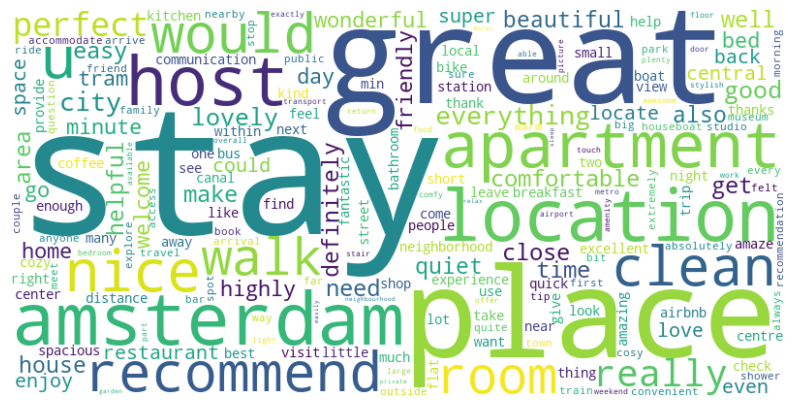

In [61]:
# Plot the word cloud
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

From the word cloud we can conclude that, the bigger the size of the word, the more frequent the word appears in the data. The following graph illustrates the word counts.

In [63]:
# Calculate word appearance frequency
freq_dist = FreqDist(all_comments_tokens)

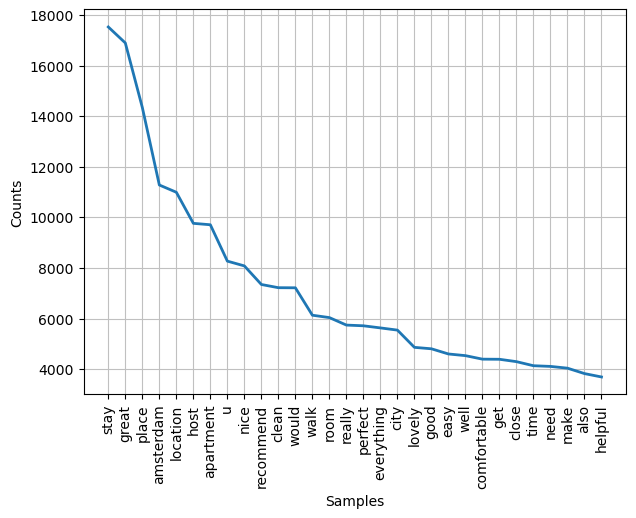

<Axes: xlabel='Samples', ylabel='Counts'>

In [64]:
# Plot the most common words
plt.figure(figsize=(7, 5))
freq_dist.plot(30, cumulative=False)

## Sentiment Analysis Modelling ##

In [66]:
clean_df.sample(7)

,reviewer_name,comments,comments_cleaned,reviewer_name_cleaned,comments_tokens,reviewer_name_tokens
15777,Chaleryl,"Amazing experience, wonderful decoration and w...",amazing experience wonderful decoration and wa...,chaleryl,"[amaze, experience, wonderful, decoration, sup...",[chaleryl]
7823,Jean Christophe,Realy nice flat near the south station (rai) a...,realy nice flat near the south station rai and...,jean christophe,"[realy, nice, flat, near, south, station, rai,...","[jean, christophe]"
21272,Toni,"The secret is out - what a great position, pla...",the secret is out what a great position place ...,toni,"[secret, great, position, place, lovely, host,...",[toni]
21003,Christin,Ralf and Karin's place was very plush and cozy...,ralf and karins place was very plush and cozy ...,christin,"[ralf, karins, place, plush, cozy, attention, ...",[christin]
14470,Amy,"Located in a safe, beautiful area of Amsterdam...",located in a safe beautiful area of amsterdam ...,amy,"[locate, safe, beautiful, area, amsterdam, coz...",[amy]
20779,Brian,"Ellen’s studio is well-located, cozy, funky, a...",ellens studio is welllocated cozy funky and fi...,brian,"[ellens, studio, welllocated, cozy, funky, fil...",[brian]
12052,Anthony,Perfect location right on the Cannel very cozy...,perfect location right on the cannel very cozy...,anthony,"[perfect, location, right, cannel, cozy, place...",[anthony]


In [67]:
# Function to perform sentiment analysis
def sentiment_analysis(clean_df):
    def getSubjectivity(text):
        return TextBlob(text).sentiment.subjectivity

    def getPolarity(text):
        return TextBlob(text).sentiment.polarity

    def getAnalysis(score):
        if score < 0:
            return 'Negative'
        elif score == 0:
            return 'Neutral'
        else:
            return 'Positive'

    # Create three new columns 'TextBlob_Subjectivity', 'TextBlob_Polarity' and 'TextBlob_Analysis'
    clean_df['TextBlob_Subjectivity'] = clean_df['comments_cleaned'].apply(getSubjectivity)
    clean_df['TextBlob_Polarity'] = clean_df['comments_cleaned'].apply(getPolarity)
    clean_df['TextBlob_Analysis'] = clean_df['TextBlob_Polarity'].apply(getAnalysis)

    return clean_df

In [68]:
# Apply sentiment analysis using TextBlob and preview the results
clean_df = sentiment_analysis(clean_df)
clean_df

,reviewer_name,comments,comments_cleaned,reviewer_name_cleaned,comments_tokens,reviewer_name_tokens,TextBlob_Subjectivity,TextBlob_Polarity,TextBlob_Analysis
0,Brian,My wife and I recently stopped in Amsterdam fo...,my wife and i recently stopped in amsterdam fo...,brian,"[wife, recently, stop, amsterdam, day, honeymo...",[brian],0.528399,0.172183,Positive
1,Kevin And Nicky,The Houseboat was truly fabulous. A great loca...,the houseboat was truly fabulous a great locat...,kevin and nicky,"[houseboat, truly, fabulous, great, location, ...","[kevin, nicky]",0.570880,0.341944,Positive
2,Mathilde,The location is perfect and the boat is perfec...,the location is perfect and the boat is perfec...,mathilde,"[location, perfect, boat, perfect, derk, reall...",[mathilde],0.680000,0.615000,Positive
3,Emily,We had such a lovely warm and comfortable stay...,we had such a lovely warm and comfortable stay...,emily,"[lovely, warm, comfortable, stay, derks, house...",[emily],0.530093,0.277037,Positive
4,Jessica,Staying on the houseboat was one of the highli...,staying on the houseboat was one of the highli...,jessica,"[stay, houseboat, one, highlight, already, won...",[jessica],0.575000,0.396296,Positive
...,...,...,...,...,...,...,...,...,...
28942,Sophie,The staff were really nice and attentive. The ...,the staff were really nice and attentive the s...,sophie,"[staff, really, nice, attentive, studio, perfe...",[sophie],0.920000,0.673333,Positive
28943,Terry,"This hotel was fantastic. Quality staff, rooms...",this hotel was fantastic quality staff rooms a...,terry,"[hotel, fantastic, quality, staff, room, ameni...",[terry],0.691667,0.305556,Positive
28944,Barry,"Great hotel, fantastic location",great hotel fantastic location,barry,"[great, hotel, fantastic, location]",[barry],0.825000,0.600000,Positive
28945,Christofer,Great place to stay,great place to stay,christofer,"[great, place, stay]",[christofer],0.750000,0.800000,Positive


## Visualization ##

In [70]:
# Count the occurrences of each sentiment
clean_df['TextBlob_Analysis'].value_counts()

TextBlob_Analysis
Positive    28307
Neutral       422
Negative      218
Name: count, dtype: int64

In [71]:
# Assign the occurrences of each sentiment into a variable for chart plotting
sentiment_counts = clean_df['TextBlob_Analysis'].value_counts()

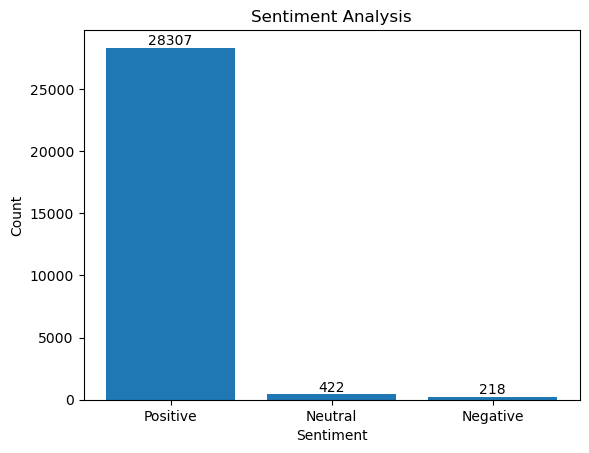

In [72]:
# Plot the sentiments
plt.bar(sentiment_counts.index, sentiment_counts.values)
labels = plt.bar_label(plt.gca().containers[0])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Analysis')

plt.show()

## Testing ##

In [74]:
# Adjust the index number for the comment's sentiment we wish to evaluate
test = TextBlob(clean_df['comments_cleaned'][1])

# Print the sentiment polarity result
print("Sentiment Polarity:", test.sentiment.polarity)

# Print the sentiment polarity result
print("Sentiment Subjectivity:", test.sentiment.subjectivity)

Sentiment Polarity: 0.34194444444444444
Sentiment Subjectivity: 0.5708796296296296


## Models Validation ##

In [76]:
# Define X and y
X = clean_df['comments_cleaned']
y = clean_df['TextBlob_Analysis']

In [77]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [78]:
# Vectorizing the text data (using TF-IDF vectorizer)
vectorizer = TfidfVectorizer(stop_words='english')
# vectorizer = TfidfVectorizer(max_features=20000)  # You can adjust max_features as needed
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

### Decision Tree ###

In [80]:
# Initialize and train and fit the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [81]:
# View the training score of the Decision Tree model
dt_train_score = dt_model.score(X_train, y_train)
print(f'Decision Tree Training Score: {dt_train_score:.4f}')

Decision Tree Training Score: 0.9999


In [82]:
# Make predictions
dt_y_predictions = dt_model.predict(X_test)

In [83]:
# Evaluate the model
dt_accuracy = accuracy_score(y_test, dt_y_predictions)
print(f'Decision Tree Testing Score: {dt_accuracy:.4f}')
print("\nClassification Report:\n", classification_report(y_test, dt_y_predictions))

Decision Tree Testing Score: 0.9781

Classification Report:
               precision    recall  f1-score   support

    Negative       0.22      0.18      0.20        45
     Neutral       0.66      0.61      0.63        87
    Positive       0.99      0.99      0.99      5658

    accuracy                           0.98      5790
   macro avg       0.62      0.59      0.61      5790
weighted avg       0.98      0.98      0.98      5790



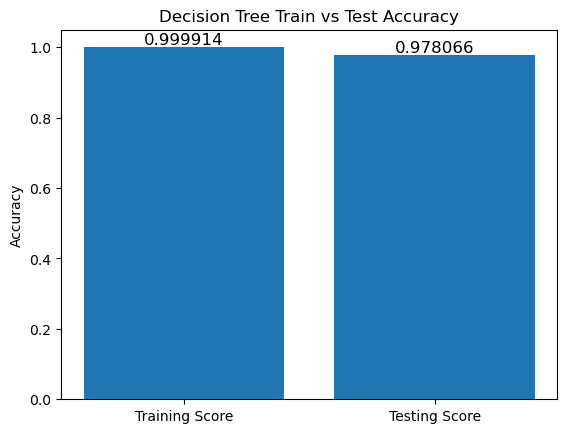

In [84]:
# Plot the Decision Tree training and testing scores
dt_scores = {'Training Score': dt_train_score, 'Testing Score': dt_accuracy}

# Create the plot
plt.bar(dt_scores.keys(), dt_scores.values())

# Add labels to each bar (using 'bar_label' function)
labels = plt.bar_label(plt.gca().containers[0])

# Set label formatting (optional)
plt.setp(labels, rotation=0, ha='center', fontsize=12)  # Rotate 0 degrees, center align, adjust font size

plt.ylabel('Accuracy')
plt.title('Decision Tree Train vs Test Accuracy')
plt.show()

In [85]:
### Perform Cross Validation Test ###

## Combine preprocessing with model training using a Pipeline to streamline the process
# Convert the text data into numerical format using TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')   # Initialize TfidfVectorizer
X_transformed = tfidf_vectorizer.fit_transform(X)   # Fit the TfidfVectorizer

# Define the pipeline
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words='english')),
    ('dt_scores', DecisionTreeClassifier(random_state=42))
])

# Perform cross-validation
dt_cv_scores = cross_val_score(pipeline, X, y, cv=10, error_score='raise')

# Output the results
print("Cross-Validation Scores:", dt_cv_scores)
print("Mean Accuracy:", np.mean(dt_cv_scores))
print("Standard Deviation of Accuracy:", np.std(dt_cv_scores))

Cross-Validation Scores: [0.98031088 0.97927461 0.97996546 0.98445596 0.9761658  0.9775475
 0.97927461 0.97581202 0.97201106 0.97926745]
Mean Accuracy: 0.9784085350788303
Standard Deviation of Accuracy: 0.0031351713022914904


### Support Vector Machine ###

In [87]:
# Training the SVM model
svm_model = SVC(kernel='linear')  # Using linear kernel for simplicity
svm_model.fit(X_train, y_train)

SVC(kernel='linear')

In [88]:
# View the training score of the SVM model
svm_train_score = svm_model.score(X_train, y_train)
print(f'SVM Training Score: {svm_train_score:.4f}')

SVM Training Score: 0.9906


In [89]:
# Make predictions
svm_y_predictions = svm_model.predict(X_test)

In [90]:
# Evaluate the model
svm_accuracy = accuracy_score(y_test, svm_y_predictions)
print(f'SVM Testing Score: {svm_accuracy:.4f}')
print("\nClassification Report:\n", classification_report(y_test, svm_y_predictions))

SVM Testing Score: 0.9862

Classification Report:
               precision    recall  f1-score   support

    Negative       1.00      0.02      0.04        45
     Neutral       1.00      0.59      0.74        87
    Positive       0.99      1.00      0.99      5658

    accuracy                           0.99      5790
   macro avg       1.00      0.54      0.59      5790
weighted avg       0.99      0.99      0.98      5790



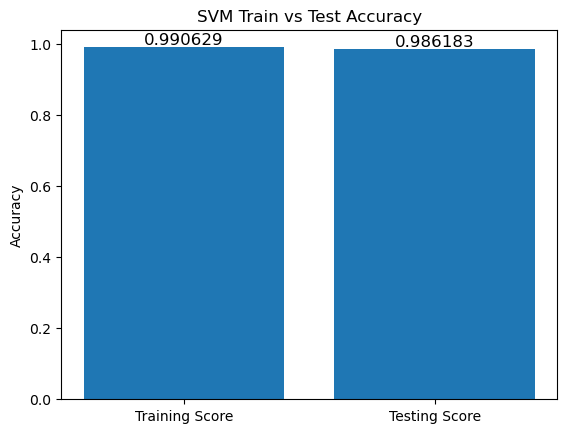

In [91]:
# Plot the SVM training and testing scores
svm_scores = {'Training Score': svm_train_score, 'Testing Score': svm_accuracy}

# Create the plot
plt.bar(svm_scores.keys(), svm_scores.values())

# Add labels to each bar (using 'bar_label' function)
labels = plt.bar_label(plt.gca().containers[0])

# Set label formatting (optional)
plt.setp(labels, rotation=0, ha='center', fontsize=12)  # Rotate 0 degrees, center align, adjust font size

plt.ylabel('Accuracy')
plt.title('SVM Train vs Test Accuracy')
plt.show()

In [92]:
### Perform Cross Validation Test ###

## Combine preprocessing with model training using a Pipeline to streamline the process
# Convert the text data into numerical format using TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')   # Initialize TfidfVectorizer
X_transformed = tfidf_vectorizer.fit_transform(X)   # Fit the TfidfVectorizer

# Define the pipeline
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words='english')),
    ('svm_scores', SVC(kernel='linear', random_state=42))
])

# Perform cross-validation
svm_cv_scores = cross_val_score(pipeline, X, y, cv=10, error_score='raise')

# Output the results
print("Cross-Validation Scores:", svm_cv_scores)
print("Mean Accuracy:", np.mean(svm_cv_scores))
print("Standard Deviation of Accuracy:", np.std(svm_cv_scores))

Cross-Validation Scores: [0.98929188 0.98480138 0.98618307 0.98687392 0.98618307 0.9865285
 0.9865285  0.98479613 0.98203179 0.98272287]
Mean Accuracy: 0.985594112289974
Standard Deviation of Accuracy: 0.0019987661223132966


### Logistic Regression ###

In [94]:
# Initialize, train and fit the Logistic Regression model
logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)

LogisticRegression()

In [95]:
# View the training score of the Logistic Regression model
logreg_train_score = logreg_model.score(X_train, y_train)
print(f'Logistic Regression Training Score: {logreg_train_score:.4f}')

Logistic Regression Training Score: 0.9856


In [96]:
# Make predictions
logreg_y_predictions = logreg_model.predict(X_test)

In [97]:
# Evaluate the model
logreg_accuracy = accuracy_score(y_test, logreg_y_predictions)
print(f'Logistic Regression Testing Score: {logreg_accuracy:.4f}')
print("\nClassification Report:\n", classification_report(y_test, logreg_y_predictions))

Logistic Regression Testing Score: 0.9858

Classification Report:
               precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        45
     Neutral       1.00      0.57      0.73        87
    Positive       0.99      1.00      0.99      5658

    accuracy                           0.99      5790
   macro avg       0.66      0.52      0.57      5790
weighted avg       0.98      0.99      0.98      5790



C:\Users\Daniel\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Daniel\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Daniel\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


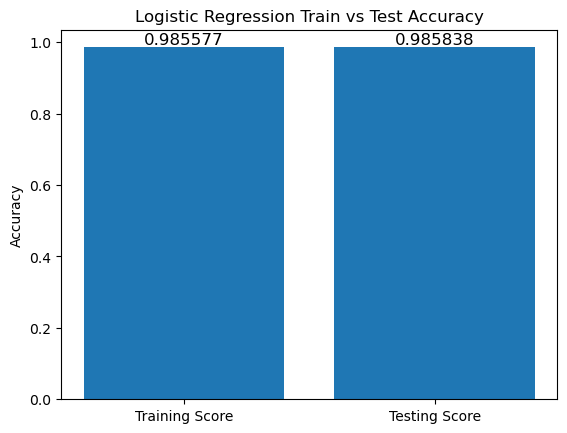

In [98]:
# Plot the LogReg training and testing scores
logreg_scores = {'Training Score': logreg_train_score, 'Testing Score': logreg_accuracy}

# Create the plot
plt.bar(logreg_scores.keys(), logreg_scores.values())

# Add labels to each bar (using 'bar_label' function)
labels = plt.bar_label(plt.gca().containers[0])

# Set label formatting (optional)
plt.setp(labels, rotation=0, ha='center', fontsize=12)  # Rotate 0 degrees, center align, adjust font size

plt.ylabel('Accuracy')
plt.title('Logistic Regression Train vs Test Accuracy')
plt.show()

In [99]:
### Perform Cross Validation Test ###

## Combine preprocessing with model training using a Pipeline to streamline the process
# Convert the text data into numerical format using TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')   # Initialize TfidfVectorizer
X_transformed = tfidf_vectorizer.fit_transform(X)   # Fit the TfidfVectorizer

# Define the pipeline
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words='english')),
    ('logreg_scores', LogisticRegression())
])

# Perform cross-validation
logreg_cv_scores = cross_val_score(pipeline, X, y, cv=10, error_score='raise')

# Output the results
print("Cross-Validation Scores:", logreg_cv_scores)
print("Mean Accuracy:", np.mean(logreg_cv_scores))
print("Standard Deviation of Accuracy:", np.std(logreg_cv_scores))

Cross-Validation Scores: [0.98929188 0.98480138 0.98583765 0.98687392 0.98618307 0.98618307
 0.98618307 0.98479613 0.98168625 0.98272287]
Mean Accuracy: 0.9854559310967961
Standard Deviation of Accuracy: 0.0020248709381070914


### Multinomial Naive Bayes ###

In [101]:
# Initialize, train and fit the Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

MultinomialNB()

In [102]:
# View the training score of the Multinomial Naive Bayes model
nb_train_score = nb_model.score(X_train, y_train)
print(f'Logistic Regression Training Score: {nb_train_score:.4f}')

Logistic Regression Training Score: 0.9850


In [103]:
# Make predictions
nb_y_predictions = nb_model.predict(X_test)

In [104]:
# Evaluate the model
nb_accuracy = accuracy_score(y_test, nb_y_predictions)

print("Accuracy:", nb_accuracy)
print("\nClassification Report:\n", classification_report(y_test, nb_y_predictions))

Accuracy: 0.9858376511226252

Classification Report:
               precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        45
     Neutral       1.00      0.57      0.73        87
    Positive       0.99      1.00      0.99      5658

    accuracy                           0.99      5790
   macro avg       0.66      0.52      0.57      5790
weighted avg       0.98      0.99      0.98      5790



C:\Users\Daniel\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Daniel\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Daniel\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


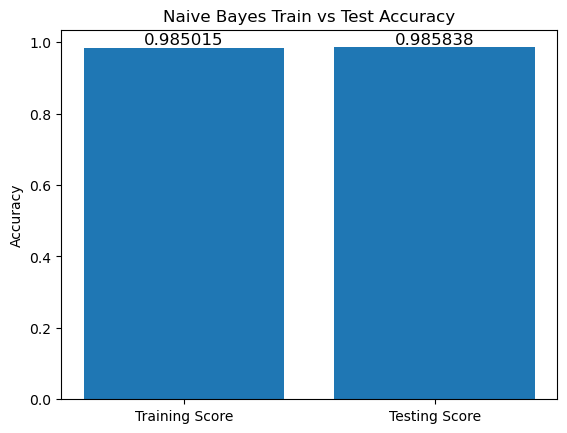

In [105]:
# Plot the Naive Bayes training and testing scores
nb_scores = {'Training Score': nb_train_score, 'Testing Score': nb_accuracy}

# Create the plot
plt.bar(nb_scores.keys(), nb_scores.values())

# Add labels to each bar (using 'bar_label' function)
labels = plt.bar_label(plt.gca().containers[0])

# Set label formatting (optional)
plt.setp(labels, rotation=0, ha='center', fontsize=12)  # Rotate 0 degrees, center align, adjust font size

plt.ylabel('Accuracy')
plt.title('Naive Bayes Train vs Test Accuracy')
plt.show()

In [106]:
### Perform Cross Validation Test ###

## Combine preprocessing with model training using a Pipeline to streamline the process
# Convert the text data into numerical format using TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')   # Initialize TfidfVectorizer
X_transformed = tfidf_vectorizer.fit_transform(X)   # Fit the TfidfVectorizer

# Define the pipeline
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words='english')),
    ('nb_scores', MultinomialNB())
])

# Perform cross-validation
nb_cv_scores = cross_val_score(pipeline, X, y, cv=10, error_score='raise')

# Output the results
print("Cross-Validation Scores:", nb_cv_scores)
print("Mean Accuracy:", np.mean(nb_cv_scores))
print("Standard Deviation of Accuracy:", np.std(nb_cv_scores))

Cross-Validation Scores: [0.98929188 0.98480138 0.98583765 0.9865285  0.98583765 0.98583765
 0.98618307 0.98479613 0.98168625 0.98237733]
Mean Accuracy: 0.985317749903618
Standard Deviation of Accuracy: 0.002029578943470252


### Random Forests ###

In [108]:
# Initialize, train and fit the Random Forests model
rf_classifier = RandomForestClassifier(n_estimators=777, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=777, random_state=42)

In [109]:
# View the training score of the Random Forests model
rf_train_score = rf_classifier.score(X_train, y_train)
print(f'Random Forests Training Score: {rf_train_score:.4f}')

Random Forests Training Score: 0.9999


In [110]:
# Make predictions
rf_y_predictions = rf_classifier.predict(X_test)

In [111]:
# Evaluate the model
rf_accuracy = accuracy_score(y_test, rf_y_predictions)
print("Accuracy:", nb_accuracy)
print("\nClassification Report:\n", classification_report(y_test, rf_y_predictions))

Accuracy: 0.9858376511226252

Classification Report:
               precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        45
     Neutral       1.00      0.60      0.75        87
    Positive       0.99      1.00      0.99      5658

    accuracy                           0.99      5790
   macro avg       0.66      0.53      0.58      5790
weighted avg       0.98      0.99      0.98      5790



C:\Users\Daniel\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Daniel\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Daniel\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


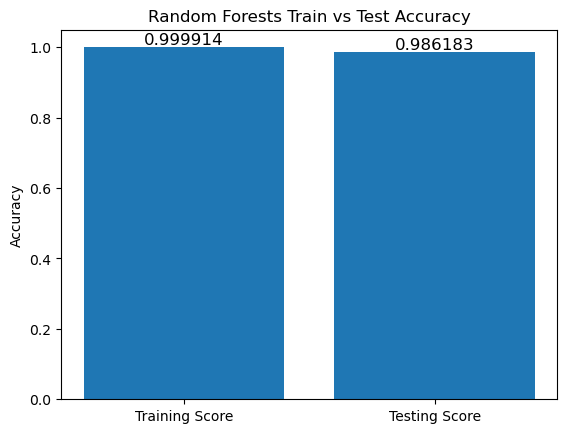

In [112]:
# Plot the LogReg training and testing scores
rf_scores = {'Training Score': rf_train_score, 'Testing Score': rf_accuracy}

# Create the plot
plt.bar(rf_scores.keys(), rf_scores.values())

# Add labels to each bar (using 'bar_label' function)
labels = plt.bar_label(plt.gca().containers[0])

# Set label formatting (optional)
plt.setp(labels, rotation=0, ha='center', fontsize=12)  # Rotate 0 degrees, center align, adjust font size

plt.ylabel('Accuracy')
plt.title('Random Forests Train vs Test Accuracy')
plt.show()

In [113]:
## This code snippet uses grid search to find the optimal number of trees based on cross-validation performance

# Define the parameter grid
param_grid = {'n_estimators': [100, 200, 500, 1000]}

# Create the model
rf = RandomForestClassifier()

# Setup the grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Get the best number of trees
best_n_estimators = grid_search.best_params_['n_estimators']
print(f"Optimal number of trees: {best_n_estimators}")

Optimal number of trees: 100


In [114]:
### Perform Cross Validation Test ###

## Combine preprocessing with model training using a Pipeline to streamline the process
# Convert the text data into numerical format using TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')   # Initialize TfidfVectorizer
X_transformed = tfidf_vectorizer.fit_transform(X)   # Fit the TfidfVectorizer

# Define the pipeline
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words='english')),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Perform cross-validation
rf_cv_scores = cross_val_score(pipeline, X, y, cv=10, error_score='raise')

# Output the results
print("Cross-Validation Scores:", rf_cv_scores)
print("Mean Accuracy:", np.mean(rf_cv_scores))
print("Standard Deviation of Accuracy:", np.std(rf_cv_scores))

Cross-Validation Scores: [0.98929188 0.98549223 0.9865285  0.98721934 0.98687392 0.98583765
 0.9865285  0.98445059 0.98272287 0.98306842]
Mean Accuracy: 0.9858013900476598
Standard Deviation of Accuracy: 0.001878025054093348


In [115]:
# Summary of cross-validation results
results = {
    'Decision Tree': {
        'mean_accuracy': np.mean(dt_cv_scores),
        'std_dev_accuracy': np.std(dt_cv_scores)
    },
    'SVM': {
        'mean_accuracy': np.mean(svm_cv_scores),
        'std_dev_accuracy': np.std(svm_cv_scores)
    },
    'Logistic Regression': {
        'mean_accuracy': np.mean(logreg_cv_scores),
        'std_dev_accuracy': np.std(logreg_cv_scores)
    },
    'Multinomial Naive Bayes': {
        'mean_accuracy': np.mean(nb_cv_scores),
        'std_dev_accuracy': np.std(nb_cv_scores)
    },
    'Random Forest': {
        'mean_accuracy': np.mean(rf_cv_scores),
        'std_dev_accuracy': np.std(rf_cv_scores)
    }
}

# Print the results of all the models
for model, metrics in results.items():
    print(f"{model}:")
    print(f"Mean Accuracy: {metrics['mean_accuracy']:.4f}")
    print(f"Standard Deviation: {metrics['std_dev_accuracy']:.4f}\n")

Decision Tree:
Mean Accuracy: 0.9784
Standard Deviation: 0.0031

SVM:
Mean Accuracy: 0.9856
Standard Deviation: 0.0020

Logistic Regression:
Mean Accuracy: 0.9855
Standard Deviation: 0.0020

Multinomial Naive Bayes:
Mean Accuracy: 0.9853
Standard Deviation: 0.0020

Random Forest:
Mean Accuracy: 0.9858
Standard Deviation: 0.0019



In [116]:
# Extracting the negative reviews
negative_sentiments_df = clean_df[clean_df['TextBlob_Analysis'] == 'Negative']

# Reset the dataset index to start from 0, then modify the index to start from 1
negative_sentiments_df.reset_index(drop=True, inplace=True)
negative_sentiments_df.index = negative_sentiments_df.index + 1

# Display the first 10 rows of the filtered DataFrame
print(negative_sentiments_df['comments_cleaned'].head(10))

# Export the filtered DataFrame to a CSV file
negative_sentiments_df.to_csv('negative_sentiments.csv', index=False)

1     our first time using airbb so we were not sure...
2     unfortunately i was not met at the place when ...
3     alexs house is extremely central and the bed i...
4     this place has an amazing location walking dis...
5     the apartment is cosy and pretty although it w...
6     we stayed on a saturday night and it was quite...
7     you know that seinfeld episode where jerry rea...
8                             clean a few things broken
9     he helped in carrying the suitcases up the nar...
10    a cosy little flat that i recommend with no he...
Name: comments_cleaned, dtype: object
